In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupShuffleSplit

from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

sns.set('notebook', style='whitegrid', font_scale=1.3)

# Валидация


В простом случае предполагается, что у нас есть данные для обучения (train set) и данные для тестирования (test set). Ответы для тестовых данных считаются неизвестными, а потому их нельзя использовать для обучения модели. 

Главная цель валидации &mdash; оценить какое качество модель способна показать на тестовых данных. Отсюда вытекает и главное правило валидации:
>  Валидационные данные должны быть как можно сильнее похожи на тестовые.

В этом ноутбуке мы обсудим различные стратегии валидации.

### Валидация на отложенной выборке (holdout validation)

При оценке качества модели нельзя использовать данные, которые использовались для ее обучения, т.к. при таком подходе мы не сможем оценить адекватность модели на новых данных и контролировать переобучение. Для решения данной проблемы существуют подходы, использующие понятие **отложенной выборки**: $X_{val}$, $Y_{val}$. Отложенной выборкой называют размеченные данные, которые мы не используем при обучении модели. 

В рассматриваемом нами случае ответы на тестовых данных неизвестны, а потому отложенную выборку мы можем сформировать лишь из обучающих данных. Такую выборку обычно называют валидационным множеством (validation set или development set).

В scikit-learn разбиение на обучающую и тестовую выборки можно легко получить с помощью функции `train_test_split`. 

Рассмотрим на примере задачи классификации ирисов.

In [2]:
# загружаем датасет 
data_full = datasets.load_iris()
print("Shape: {}".format(data_full.data.shape))

Shape: (150, 4)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    # *arrays: принимает индексируемые объекты с совпадающей shape[0]. 
    # Например: list, np.array, pd.DataFrame.
    data_full.data, data_full.target,
    test_size=0.4,  # доля данных, которые берем в тестовую выборку
    random_state=0,  # фиксируем случайность
    shuffle=True,  # перемешивает данные в случайном порядке 
    stratify=None  # если не None, то сохраняет доли классов при разбиении
)

In [4]:
print("Shape of train data: {} {}".format(X_train.shape, y_train.shape))
print("Shape of test data: {} {}".format(X_test.shape, y_test.shape))

Shape of train data: (90, 4) (90,)
Shape of test data: (60, 4) (60,)


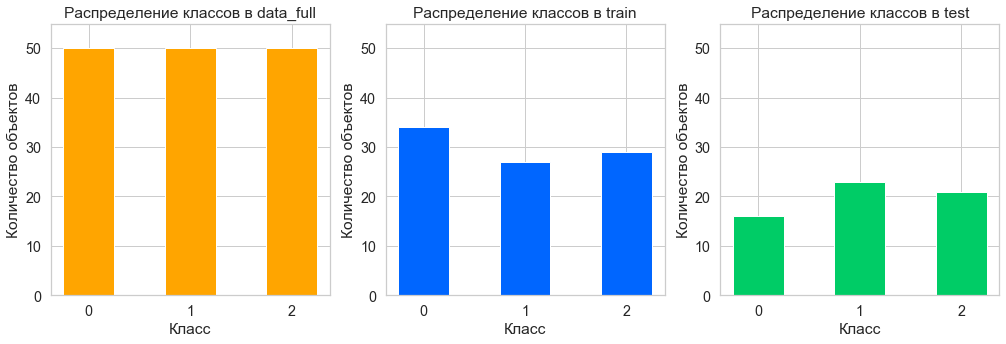

In [5]:
plt.figure(figsize=(17,5))
split_cases = [data_full.target, y_train, y_test]
colors = ['orange', '#0066FF', '#00CC66']
labels = ['Распределение классов в data_full', 
          'Распределение классов в train', 
          'Распределение классов в test']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    values, counts = np.unique(split_cases[i], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i])
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    plt.xlabel('Класс')
    plt.ylabel('Количество объектов')
    plt.title(labels[i])
plt.show()

Видим, что распределение классов в обучающей и тестовой выборках отличаются. Теперь попробуем сделать разбиение с `stratify = data_full.target`. Стратификация &mdash; стратегия кросс-валидации, при которой в обучающей и тестовой выборке сохраняется одинаковое распределение целевой переменной, такое же, как во всем датасете. Зачем нужна стратификация узнаем чуть позже.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    # *arrays: принимает индексируемые объекты с совпадающей shape[0]. 
    # Например: list, np.array, pd.DataFrame.
    data_full.data, data_full.target,
    test_size=0.4, # доля данных, которые берем в тестовую выборку
    random_state=0, # фиксируем случайность
    shuffle=True, # перемешивает данные в случайном порядке 
    # сохраняем доли классов при разбиении как в таргете
    stratify=data_full.target
)

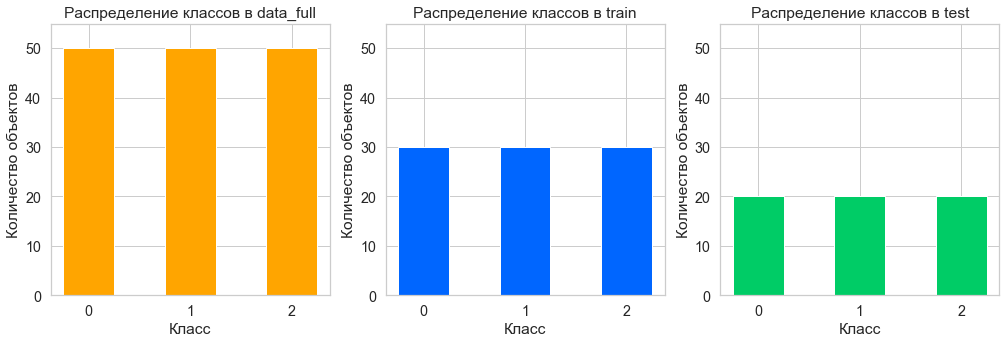

In [7]:
plt.figure(figsize = (17,5))
split_cases = [data_full.target, y_train, y_test]
colors = ['orange', '#0066FF', '#00CC66']
labels = ['Распределение классов в data_full', 
          'Распределение классов в train', 
          'Распределение классов в test']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    values, counts = np.unique(split_cases[i], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i])
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    plt.xlabel('Класс')
    plt.ylabel('Количество объектов')
    plt.title(labels[i])
plt.show()

Видим, что после разбиения с `stratify = data_full.target` распределения классов в train и test не отличаются. 

Подведем итог для метода отложенной выборки.

**Достоинства:**
* Быстрый для оценки качества модели. При использовании данной техники разбиения данных для оценки качества модели происходит одна процедура обучения на обучающей выборке, после чего качество модели оценивается на тестовых данных. 

**Недостатки:**
* Результат сильно зависит от способа разбиения. Объекты в train и test могут получиться из разных распределений, если `stratify = False`.
* При обучении модели на обучающей выборке валидационная выборка не используется, то есть мы не задействуем все доступные данные для обучения.
* При оптимизации значения метрики на валидационном множестве модель немного переобучается под него. Таким образом, значение метрики качества на новых данных не будет соответствовать значению метрики на тестовом множестве.

## Кросс-валидация (cross-validation)

### k-Fold Cross Validation

Описанные выше недостатки оказались критичны, поэтому для борьбы с ними придумали кросс-валидацию. **Кросс-валидация** &mdash; это метод оценки качества модели, при котором обучающая выборка делится на $k$ частей, или **фолдов**. После чего для каждого из $k$ фолдов проделывается следующая процедура: 
* модель обучается на остальных $k-1$ фолдах, которые вместе формируют обучающую выборку для данной итерации
* обученная модель оценивается на оставшемся $k$-ом фолде  

Таким образом мы получаем $k$ оценок качества. Итоговая метрика считается как среднее полученных оценок. Ниже представлена визуализация рассматриваемой стратегии кросс-валидации для пяти фолдов. 

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="40%">

Рассмотрим пример. Будем использовать данные о ценах квартир в Бостоне.

In [8]:
boston = datasets.load_boston() # данные о ценах квартир в Бостоне
X = pd.DataFrame(data=boston['data'], columns= boston['feature_names'])
y = boston['target']

Описание датасета.

In [9]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [11]:
X.shape

(506, 13)

При помощи функции [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) можем получить значение выбранной метрики на всех фолдах.

В качестве примера применим ее к линейной модели.

In [12]:
model = LinearRegression()
scores = cross_val_score(
    estimator=model, # модель, качество которой хотим оценить
    X=X, # данные для обучения (не содержат целевую переменную)
    y=y, # значения целевой переменной
    cv=5, # количество фолдов
    scoring='neg_mean_squared_error', # метрика качества
    n_jobs=-1 # количество ядер для вычислений, -1 - использование всех ядер
)
scores

array([-12.46030057, -26.04862111, -33.07413798, -80.76237112,
       -33.31360656])

Стоит отметить, что в качестве scoring мы используем `neg_mean_squared_error`. Префикс neg показывает, что мы оптимизируем $(-1) \cdot \mathrm{MSE}$. Дело в том, что оптимизации в sklearn подразумевают **максимизацию** метрики качества.

Посмотрим на распределение цен, чтобы понимать в каком масштабе находятся значения MSE. 

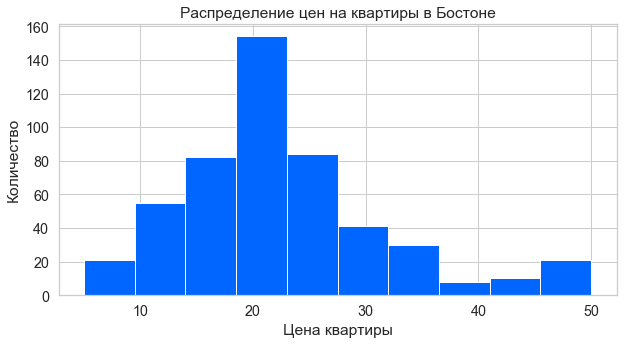

In [13]:
plt.figure(figsize=(10,5))
plt.hist(y, color='#0066FF')
plt.xlabel('Цена квартиры')
plt.ylabel('Количество')
plt.title('Распределение цен на квартиры в Бостоне')
plt.show()

Визуализируем MSE на всех фолдах.

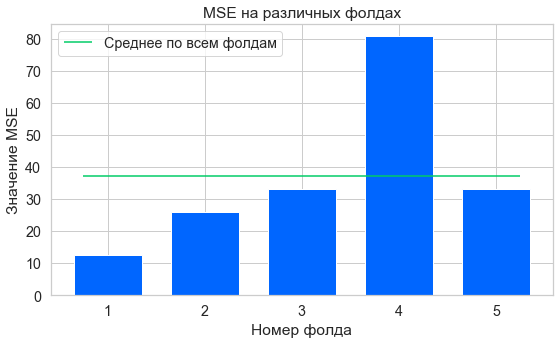

In [14]:
plt.figure(figsize=(9,5))
plt.bar(range(1, 6), (-1)*scores, width=0.7, color='#0066FF')
plt.hlines(np.mean((-1)*scores), 0.75, 5.25, color='#00CC66', 
           label='Среднее по всем фолдам')
plt.xlabel('Номер фолда')
plt.ylabel('Значение MSE')
plt.title('MSE на различных фолдах')
plt.legend()
plt.show()

Видим, что значения достаточно сильно различаются.

Полезно знать:  
* [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) &mdash; позволяет задать сразу несколько метрик для подсчета качества модели. Возвращаем значения данных метрик для каждой итерации кросс-валидации в виде словаря.
* [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) &mdash; возвращает предсказания, полученные для каждого объекта выборки при кросс-валидации.

Выше мы рассмотрели функцию `cross_val_score`, которая имеет аргумент `cv`. По умолчанию данный аргумент использует стратегию кросс-валидации KFold, но ему можно передавать и другие стратегии кросс-валидации. Рассмотрим аналогичный способ использования KFold кросс-валидации, который на практике является более гибким. 

Задаем стратегию кросс-валидации KFold.

In [15]:
kf = KFold(
    n_splits=2,  # количество фолдов 
    shuffle=False  # перемешиваем ли данные перед разбиением
)
kf

KFold(n_splits=2, random_state=None, shuffle=False)

В sklearn объекты классов, которые соответствуют стратегиям кросс-валидации, обычно имеют два метода:
* `get_n_splits` &mdash; возвращает количество итераций, которое необходимо для заданной стратегии кросс-валидации;
* `split` &mdash; возвращает генератор индексов для разбиения данных на train и test.

*Замечание.*

У этого класса нет никакого механизма стратификации.

In [16]:
kf.get_n_splits()

2

In [17]:
kf.split(
    X=X  # данные для разбиения
)

<generator object _BaseKFold.split at 0x7f4414bbe1d0>

Приведем пример, демонстрирующий работу метода `split`.

In [18]:
data = np.array([[81, 27], [26, 45], [83, 64], [25, 98]])
data

array([[81, 27],
       [26, 45],
       [83, 64],
       [25, 98]])

In [19]:
for train_index, test_index in kf.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


Случай, когда аргумент `cv` функции `cross_val_score` принимает на вход стратегию кросс-валидации. На выходе функции получаем значения метрик для каждой итерации кросс-валидации.

In [20]:
scores = cross_val_score(estimator=model, X=X, y=y, cv=kf, 
                         scoring='neg_mean_squared_error')
scores

array([ -27.21869349, -303.43686293])

Визуальная интерпретация KFold кросс-валидации:  
![kFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_002.png)



На данном графике представлена 4-Fold CV (сокращение от Cross-Validation). Каждую горизонтальную полосу стоит понимать как одну и ту же выборку из 100 элементов. По горизонтальной оси показан номер элемента выборки. По вертикальной оси сверху отложены номера фолдов. Снизу отложены разбиения выборки по классу (целевая переменная) и какому-то категориальному признаку (группа). О группах будет сказано чуть позже.

**Достоинства:**  
* Оценивается качество модели, полученное при обучении на всех данных.  
* При подборе гиперпараметров можем контролировать переобучение, т.к. выбирается модель, показавшая лучшее качество на отложенных (тестовых) фолдах. Переобучение &mdash; это ситуация, когда модель показывает хорошее качество на обучающей выборке, но плохое качество на отложенной выборке.


**Недостатки:**
* Значительная вычислительная сложность. Вместо одной процедуры обучения приходится обучать модель $k$ раз. 
* Никак не учитывает распределение значений целевой переменной.
* Не учитывает разбиение объектов на группы (что это такое разберемся чуть ниже).